#Import data - Sentiment140 dataset

In [ ]:
# loading the train & test csv file from link in pdf
!mkdir -p data
!wget -nc http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -P data
!unzip -n -d data data/trainingandtestdata.zip


--2022-03-06 20:27:41--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2022-03-06 20:27:42--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘data/trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  32.7MB/s    in 2.4s    

2022-03-06 20:27:44 (32.7 MB/s) - ‘data/trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  data/trainingandtestdata.zip
  inflating: data/testdata.manual.2009.06.14.csv  
  inflating: data/training.1600000.processed.noemoticon.csv  


#Data preprocess

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from scipy.special import factorial
from scipy.sparse import vstack
import math
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings

def data_process():
    #dataframe of training set
    df_train = pd.read_csv("data/training.1600000.processed.noemoticon.csv", names=['polarity', 'id', 'date', 'query', 'user', 'text'], encoding='latin-1')
    df_train = df_train[['polarity', 'text']]
    #dataframe of testing set
    df_test = pd.read_csv("data/testdata.manual.2009.06.14.csv", names=['polarity', 'id', 'date', 'query', 'user', 'text'])
    df_test = df_test.loc[df_test.polarity!=2].reset_index()
    df_test = df_test[['polarity', 'text']]
    #delete links and numbers in text
    df_train['text']=df_train['text'].apply(lambda x: re.sub('http://\S+|https://\S+|@\S+|[0-9]\S+','', str(x)))
    df_test['text']=df_test['text'].apply(lambda x: re.sub('http://\S+|https://\S+|@\S+|[0-9]\S+','', str(x)))
    #delete special characters from text
    df_train['text']=df_train['text'].apply(lambda x: re.sub('[^A-Za-z]+',' ', str(x)))
    df_test['text']=df_test['text'].apply(lambda x: re.sub('[^A-Za-z]+',' ', str(x)))
    #remove duplicate rows
    df_train.drop_duplicates("text", inplace=True)
    df_test.drop_duplicates("text", inplace=True)
    #modify the column polarity with binary value
    df_train.polarity = df_train.polarity.replace({0: 0, 4: 1})
    df_test.polarity = df_test.polarity.replace({0: 0, 4: 1})

    return df_train, df_test


# CLass Distribution

In [ ]:
#generate a bar graph to show the class distribution of the dataset#1
def plot_class_distribution(df_train, df_test):
    polarity, number1 = np.unique(df_train.polarity, return_counts=True)
    target, number2 = np.unique(df_test.polarity, return_counts=True)

    index = ['Negative', 'Positive']
    df = pd.DataFrame({'train': [number1[0],number1[1]],'test': [number2[0],number2[1]]}, index=index)
    ax = df.plot.bar(rot=0,subplots=True,title="The plot of class distribution in Sentiment140 dataset",layout=(1,2),legend=False)


# Set up continuous features (tfidf) for Gaussian Naive Bayes

In [ ]:
#turn the text data of training/test set (exclude stop words) into numerical features (computing word tfidf)
df_train, df_test = data_process()
count_vect = TfidfVectorizer(stop_words='english',max_df=0.5,min_df=5,max_features=1000)
train_feature_count = count_vect.fit_transform(df_train.text)
test_feature_count = count_vect.transform(df_test.text)
#check dictionary of words with frequency
print(count_vect.vocabulary_)

# Set up "count" features for Multinomial Naive Bayes

In [ ]:
#turn the text data of training/test set (exclude stop words) into numerical features (counting word frequency)
count_vect1 = CountVectorizer(stop_words='english',max_df=0.5,min_df=5,max_features=1000)
train_feature_count1 = count_vect1.fit_transform(df_train.text)
test_feature_count1 = count_vect1.transform(df_test.text)

# Gaussian and Multinomial Naive Bayes Implementation

In [ ]:
def gaussian(self, xt):
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None]
    threshold=+1e-20
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]+threshold) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/(self.sigma[:,None,:]+threshold))**2)
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return log_posterior.T

def multinomial(self, xt):
    log_posteriors = np.zeros((xt.shape[0],2))
    for i in range(xt.shape[0]):
        log_posteriors[i,:]=(((self.likelihood)*(xt[i,:].T)).sum(axis=1)).T+(self.prior).T
    return log_posteriors

class NaiveBayes:
    
    def __init__(self, NB_fn=multinomial):
        self.NB_fn = NB_fn
        return
    
    def fit(self, x, y, alpha=0.5):
        #N: number of instance, D:number of feature
        N, D = x.shape
        #C: number of class
        C = np.max(y) + 1
        #one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        prior = np.zeros(C)
        likelihood = np.zeros((C, D))
        Nc = np.zeros(C)
        # for each class get the MLE for the mean and std
        for c in range(C):
            #slice all the elements from class c
            x_c = x[y == c] 
            #get number of elements of class c
            Nc[c] = x_c.shape[0]
            #prepare the prior and likelihood basedon the input training set
            prior[c]=np.log(Nc[c]/ N)
            likelihood[c, :] = np.log((x_c.sum(axis=0) + alpha)/(x_c.sum(axis=1).sum(axis=0)+alpha*D))
            #mean of features of class c
            mu[c,:]=x_c.mean(axis=0)
            #std of features of class c
            x_c_temp = x_c.copy()
            x_c_temp.data **= 2
            variance=x_c_temp.mean(axis=0) - np.square(mu[c,:])
            sigma[c,:] = np.sqrt(variance)

        self.alpha=alpha    
        self.C=C
        self.prior = prior
        self.likelihood = likelihood
        self.mu = mu                                  
        self.sigma = sigma     
        #Laplace smoothing (using alpha_c=1 for all c)                        
        self.pi = (Nc+1)/(N+C)
        return self

def logsumexp(Z):                                                
    Zmax = np.max(Z,axis=0)[None,:]
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    posterior = self.NB_fn(self, xt)
    return posterior                                              

NaiveBayes.predict = predict

#function to evaluate the accuracy of the model
def evaluate_acc(y_test, y_predict):
    accuracy = np.sum(y_predict == y_test)/y_predict.shape[0]
    return accuracy

#function takes the training data as input and splits it into k folds 
#where 1 fold for validation set and k-1 folds for training set 
def cross_validation_split(x_train_origin, y_train_origin, k_folds=5):
    index = np.arange(np.shape(x_train_origin)[0])
    np.random.shuffle(index)
    x_train_origin, y_train_origin = x_train_origin[index], y_train_origin[index]
    val_x=[]
    val_y=[]
    train_x=[]
    train_y=[]
    for i in range(k_folds):
        
        fold_len=x_train_origin.shape[0]//k_folds
        val_x.append(x_train_origin[i*fold_len:fold_len*(i+1)])
        train_x1 = x_train_origin[0*fold_len:i*fold_len]
        train_x2 = x_train_origin[fold_len*(i+1):]
        train_x.append(vstack([train_x1, train_x2]))
        split_y = np.array_split(y_train_origin, k_folds)
        val_y.append(split_y.pop(i))
        train_y.append(np.concatenate(split_y))  
    return val_x, val_y, train_x, train_y

#function takes train/validation sets generated above and a given model as input
#iterate through each train/validation set and returns the average result of each fold
def kfoldCV(x_valid, y_valid, x_train, y_train, model, alpha=0.05):
    accuracy_list=[]
    for s in range(len(x_valid)):
        model.fit(x_train[s], y_train[s], alpha)
        y_prob = model.predict(scipy.sparse.csr_matrix.toarray(x_valid[s]))
        y_pred = np.argmax(y_prob, 1)
        accuracy_list.append(evaluate_acc(y_valid[s], y_pred))
    acc = sum(accuracy_list)/len(accuracy_list)
    print(accuracy_list)
    print(f'test accuracy: {acc}')
    return acc




In [ ]:
#set up the simple logistic model based on whole training set and test the model by test set to get the initial accuracy 
filterwarnings('ignore') # ignor the convergence warning
#logistice model for count features
clf = LogisticRegression(random_state=0).fit(train_feature_count, df_train.polarity.to_numpy())
y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(test_feature_count))
acc = evaluate_acc(df_test.polarity, y_prob)
print(f'test accuracy: {acc}')
#logistice model for continous features
clf=LogisticRegression(random_state=0).fit(train_feature_count1, df_train.polarity.to_numpy())
y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(test_feature_count1))
acc = evaluate_acc(df_test.polarity, y_prob)
print(f'test accuracy: {acc}')

test accuracy: 0.7827298050139275
test accuracy: 0.7771587743732591


#cross-validation for hyperparameter of Naive Bayes

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#find max_feature that will result in the best performance
#compare the overall performance for multinomial and guassian Naive Bayes
def cv_max_feature(df_train):
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    model1 = NaiveBayes(NB_fn=multinomial)
    max_feature1=[]
    accuracy1=[]
    for i in range(1000,15000,2000):
        print(i)
        max_feature1.append(i)
        count_vect = CountVectorizer(stop_words='english', min_df=1,max_features=i)
        train_feature_count = count_vect.fit_transform(df_train1.text)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        accuracy1.append(kfoldCV(x_valid1, y_valid1, x_train1, y_train1, model1))

    model = NaiveBayes(NB_fn=gaussian)
    max_feature=[]
    accuracy=[]
    for i in range(100,7000,500):
        print(i)
        max_feature.append(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=i)
        train_feature_tfidf = tfidf_vect.fit_transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf, df_train1.polarity, 5)
        accuracy.append(kfoldCV(x_valid, y_valid, x_train, y_train, model))
    #generate the line graph
    plt.plot(max_feature1, accuracy1, label="Multinomial Naive Bayes")
    plt.errorbar(max_feature, accuracy, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different # features in 5 fold cross-validation')
    plt.xlabel('number of features')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

#find max_df that will result in the best performance of the Naive Bayes model
#compare the overall performance for multinomial and guassian Naive Bayes
def cv_max_df(df_train):
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    model = NaiveBayes(NB_fn=multinomial)
    max_df=[]
    accuracy_multinomial=[]
    # max_df = 0.1 means ignore the words occur in more than 10% of the documents
    for i in range(1,10,2):
        i = i/10
        print(i)
        max_df.append(i)
        count_vect1 = CountVectorizer(stop_words='english', max_features=6000, max_df=i)
        train_feature_count1 = count_vect1.fit_transform(df_train1.text)
        test_feature_count1 = count_vect1.transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, df_train1.polarity, 5)
        accuracy_multinomial.append(kfoldCV(x_valid, y_valid, x_train, y_train, model))

    accuracy_gaussian=[]
    model1 = NaiveBayes(NB_fn=gaussian)
    for i in range(1,10,2):
        i = i/10
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=6000, max_df=i)
        train_feature_tfidf = tfidf_vect.fit_transform(df_train1.text)
        test_feature_tfidf = tfidf_vect.transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf,  df_train1.polarity, 5)
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model1)) # 1 indicate using Gaussian NB

    #generate the line graph
    plt.plot(max_df, accuracy_multinomial, label="Multinomial Naive Bayes")
    plt.plot(max_df, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different max_df in 5 fold cross-validation')
    plt.xlabel('max_df')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,30,2))
    plt.legend()
    plt.show()

#find min_df that will result in the best performance of the Naive Bayes model
def cv_min_df(df_train):
    model = NaiveBayes(NB_fn=multinomial)
    min_df=[]
    accuracy=[]
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    for i in range(0,20,2):
        print(i)
        min_df.append(i)
        count_vect1 = CountVectorizer(stop_words='english',min_df=i,max_features=6000)
        train_feature_count1 = count_vect1.fit_transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, df_train1.polarity, 5)
        accuracy.append(kfoldCV(x_valid, y_valid, x_train, y_train, model))

    accuracy_gaussian=[]
    model1 = NaiveBayes(NB_fn=gaussian)
    for i in range(0,20,2):
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=6000, min_df=i)
        train_feature_tfidf = tfidf_vect.fit_transform(df_train1.text)
        test_feature_tfidf = tfidf_vect.transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf,  df_train1.polarity, 5)
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model1)) # 1 indicate using Gaussian NB

    #generate the line graph
    plt.plot(min_df, accuracy, label="Multinomial Naive Bayes")
    plt.plot(min_df, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different min_df in 5 fold cross-validation')
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

#find the best hyperparameter alpha that will result in the best performance of the multinomial Naive Bayes model
def cv_alpha(df_train):
    model = NaiveBayes(NB_fn=multinomial)
    alpha=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
    accuracy=[]
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    for i in alpha:
        print(i)
        count_vect1 = CountVectorizer(stop_words='english',max_features=6000)
        train_feature_count1 = count_vect1.fit_transform(df_train1.text)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, df_train1.polarity, 5)
        accuracy.append(kfoldCV(x_valid, y_valid, x_train, y_train, model,i))

    #generate the line graph
    plt.plot(alpha, accuracy, label="Multinomial Naive Bayes")
    plt.title('Plot of models with different alpha in 5 fold cross-validation')
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

#cross-validation for hyperparameter of Softmax Regression

In [ ]:
def cv_max_iter(df_train):
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    count_vect1 = CountVectorizer(stop_words='english',max_features=6000)
    train_feature_count = count_vect1.fit_transform(df_train1.text)
    filterwarnings('ignore')
    iteration=[]
    accuracy=[]
    for i in range(0,50,2):
        print(i)
        iteration.append(i)
        a=[]
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=i).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        print(sum(a)/len(a))
        accuracy.append(sum(a)/len(a))

    plt.plot(iteration, accuracy, label="Logistic Regression")
    plt.title('Plot of softmax models with different max iterations in 5 fold cross-validation')
    plt.xlabel('number of iterations')
    plt.ylabel('accuracy')
    plt.xticks(range(0,50,2))
    plt.legend()
    plt.show()
    
def cv_C(df_train):
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    count_vect1 = CountVectorizer(stop_words='english',max_features=6000)
    train_feature_count = count_vect1.fit_transform(df_train1.text)
    filterwarnings('ignore')
    c=[]
    accuracy=[]
    for i in range(1,100,5):
        print(i/100)
        c.append(i/100)
        a=[]
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=20,C=i/100).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        print(sum(a)/len(a))
        accuracy.append(sum(a)/len(a))

    plt.plot(c, accuracy, label="Logistic Regression")
    plt.title('Plot of softmax models with different C in 5 fold cross-validation')
    plt.xlabel('C - Inverse of regularization strength')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,1,0.1))
    plt.legend()
    plt.show()

def cv_penalty(df_train):
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    count_vect1 = CountVectorizer(stop_words='english',max_features=6000)
    train_feature_count = count_vect1.fit_transform(df_train1.text)
    filterwarnings('ignore')
    penalty=['none','l2']
    accuracy=[]
    for i in penalty:
        print(f'the norm of the penalty: {i}')
        a=[]
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=20,C=0.21,penalty=i).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        accuracy=sum(a)/len(a)
        print(f'test accuracy: {accuracy}')
    

# Compare performance of naive Bayes and softmax regression

In [ ]:
filterwarnings('ignore')
def cv_NB_SR():
    accuracy1=[]
    accuracy=[]
    num_feature=[]
    #randomly select 100000 instances as the training set to avoiding the memory problem
    df_train1=df_train.sample(n=100000,ignore_index=True)
    model1 = NaiveBayes(NB_fn=multinomial)
    for i in range(1000,29000,1000):
        print(i)
        num_feature.append(i)
        count_vect = CountVectorizer(stop_words='english',max_features=i)
        train_feature_count = count_vect.fit_transform(df_train1.text)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        a1=kfoldCV(x_valid1, y_valid1, x_train1, y_train1, model1, alpha=0.06)
        accuracy1.append(a1)
        print(f'The test accuracy for multinomial Naive Bayes with best hyperparameter is: {a1}')

        a=[]
        for s in range(len(x_valid1)):
            clf = LogisticRegression().fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        accuracy.append(sum(a)/len(a))
        print(f'The test accuracy for Softmax Regression with best hyperparameter is: {sum(a)/len(a)}')
    plt.plot(num_feature, accuracy1, label="Multinomial Naive Bayes")
    plt.errorbar(num_feature, accuracy, label="Softmax Regression")
    plt.title('Plot of models with different number of features in 5 fold cross-validation')
    plt.xlabel('number of features')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# Compare accuracy of the two models as a function of the size of dataset

In [ ]:
def cv_size_of_dataset():
    percent=[]
    accuracy1=[]
    accuracy=[]

    for i in range(2,10,2):
        print(f'{i*10} % of the avaliable training set')
        percent.append(i/10)
        #randomly select 100000*percent instances as the training set( *100000 to avoiding the memory problem
        df_train1=df_train.sample(n=int(100000*i/10),ignore_index=True)
        model1 = NaiveBayes(NB_fn=multinomial)
        count_vect = CountVectorizer(stop_words='english',max_features=6000)
        train_feature_count = count_vect.fit_transform(df_train1.text)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        accuracy1.append(kfoldCV(x_valid1, y_valid1, x_train1, y_train1, model1, alpha=0.06))
        #print(f'The test accuracy for multinomial Naive Bayes is: {accuracy1}')

        a=[]
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, df_train1.polarity, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=20,C=0.21,penalty='l2').fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        accuracy.append(sum(a)/len(a))
        #print(f'The test accuracy for Softmax Regression with best hyperparameter is: {accuracy}')

    plt.plot(percent, accuracy1, label="Multinomial Naive Bayes")
    plt.errorbar(percent, accuracy, label="Softmax Regression")
    plt.title('Plot of models with different percent of training data in 5 fold cross-validation')
    plt.xlabel('percent of training data')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


#Main Function

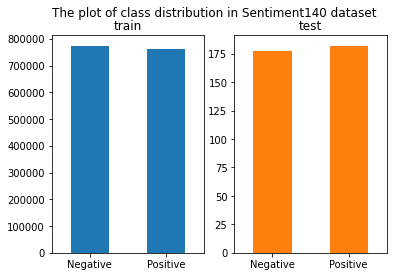

In [ ]:
def main():
    df_train, df_test = data_process()
    plot_class_distribution(df_train, df_test)
    #model = NaiveBayes()

    np.seterr(all = 'ignore') 
    
    #cv_max_feature(df_train)
    #cv_max_df(df_train)
    #cv_min_df(df_train)
    #cv_alpha(df_train)
    #cv_max_iter(df_train)
    #cv_C(df_train)
    #cv_penalty(df_train)
    #cv_NB_SR()
    #cv_size_of_dataset()
    """
    model = NaiveBayes()
    for k in range(10,11):
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count, df_train.polarity, k)
        kfoldCV(x_valid, y_valid, x_train, y_train, model)
    
    model.fit(train_feature_count1, df_train.polarity.to_numpy())
    y_prob = model.predict(scipy.sparse.csr_matrix.toarray(test_feature_count1))

    y_pred = np.argmax(y_prob, 1)
    print(y_pred)
    acc=evaluate_acc(df_test.polarity, y_pred)
    
    print(f'test accuracy: {acc}')
    """
main()